## Initial setup, packages installation, and loading the necessary libraries.

In [1]:
import os
import time
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.image as mpimg
from utils import *

%matplotlib inline

## Building a Model to Classify Retinal Disease

 > ## 1.1 Exploratory Data Analysis

In [2]:
train_df = load_data('data/train/train.csv', ',')
print(train_df.shape)

# Let's visualize some rows of the data. The first columns corresponds to the
# image file and the rest if the image contain any of the retinal disease.
train_df.head(100)

FILE EXIST
(3435, 8)


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
95,8518b692368f.jpg,1,1,0,1,0,0,0
96,7a3e5d2d09bc.jpg,1,1,0,1,0,0,0
97,b58ca12cea1b.jpg,1,0,0,0,0,0,0
98,698d188ddd7d.jpg,1,0,0,0,0,0,0


Let's visualize now some of the images corresponding to each retinal disease. This will help us to understand a bit better the problem at hand.

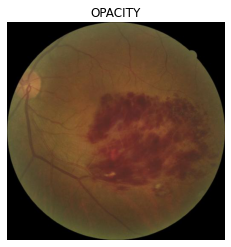

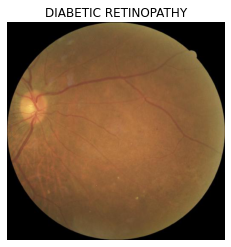

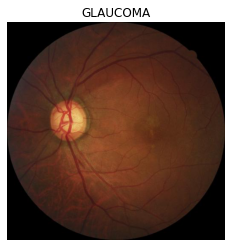

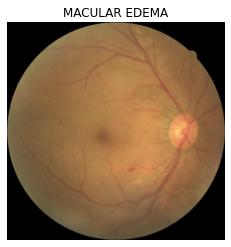

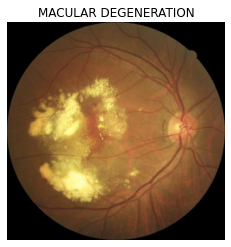

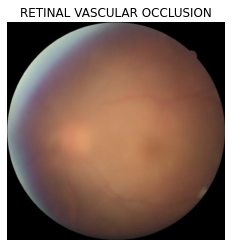

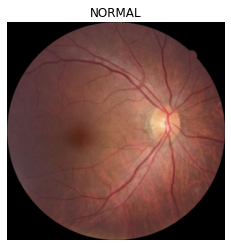

In [3]:
# Examples of retinal images corresponding to each category.
disease_labels = train_df.columns[1:]
    
for i in disease_labels:
      image_file = train_df.loc[train_df[i] == 1, 'filename'].sample().values[0]
      image = mpimg.imread('data/train/train/'+image_file)
    
      plt.title(i.upper())
      plt.axis("off")
      plt.imshow(image)
      plt.show()

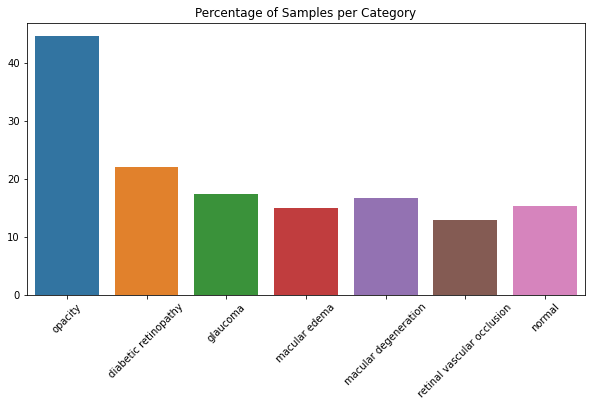

retinal vascular occlusion     440
macular edema                  516
normal                         525
macular degeneration           574
glaucoma                       597
diabetic retinopathy           755
opacity                       1533
dtype: int64


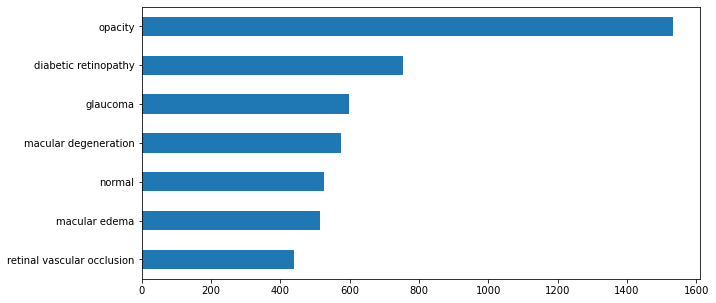

In [4]:
# Display the percentage and number of samples per disease label.
category_percentage(train_df, disease_labels)

plt.figure(figsize=(10, 5))
train_df[disease_labels].sum().sort_values().plot(kind='barh')
print(train_df[disease_labels].sum().sort_values())
plt.show()

After inspecting the previous graph it is evident that our data is imbalanced. There are for example 1000 (approx.) cases more of the label "*opacity*" compared to most of the other labels. 

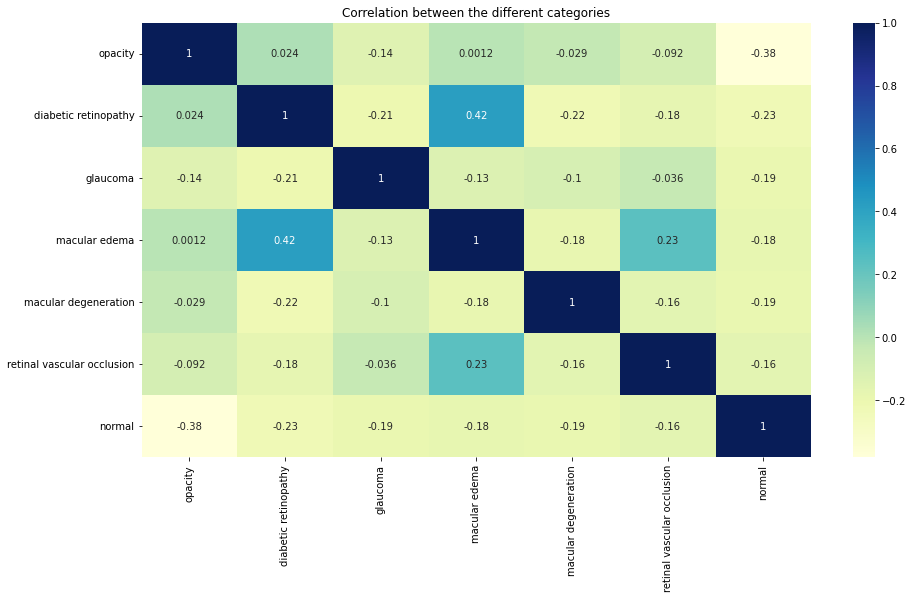

In [5]:
# Correlation between disease.
correlation_between_labels(train_df)

According to the correlation matrix, it seems there is no significant correlation between the different retinal disorders that are present in this dataset.

There is just a minor correlation  (`0.42`) between '*diabetic retinopathy*' and '*macular edema*', and (`0.23`) between '*macular edema*' and '*retinal vascular occlusion*'. Therefore, it shouln't be surprising that after training a model with this data, and when making predictions to an image with either '*diabetic retinopathy*' or '*macular edema*', then the image could get both labels.

A correlation is considered significant for values above `0.5` with a `p-value<0.05`.

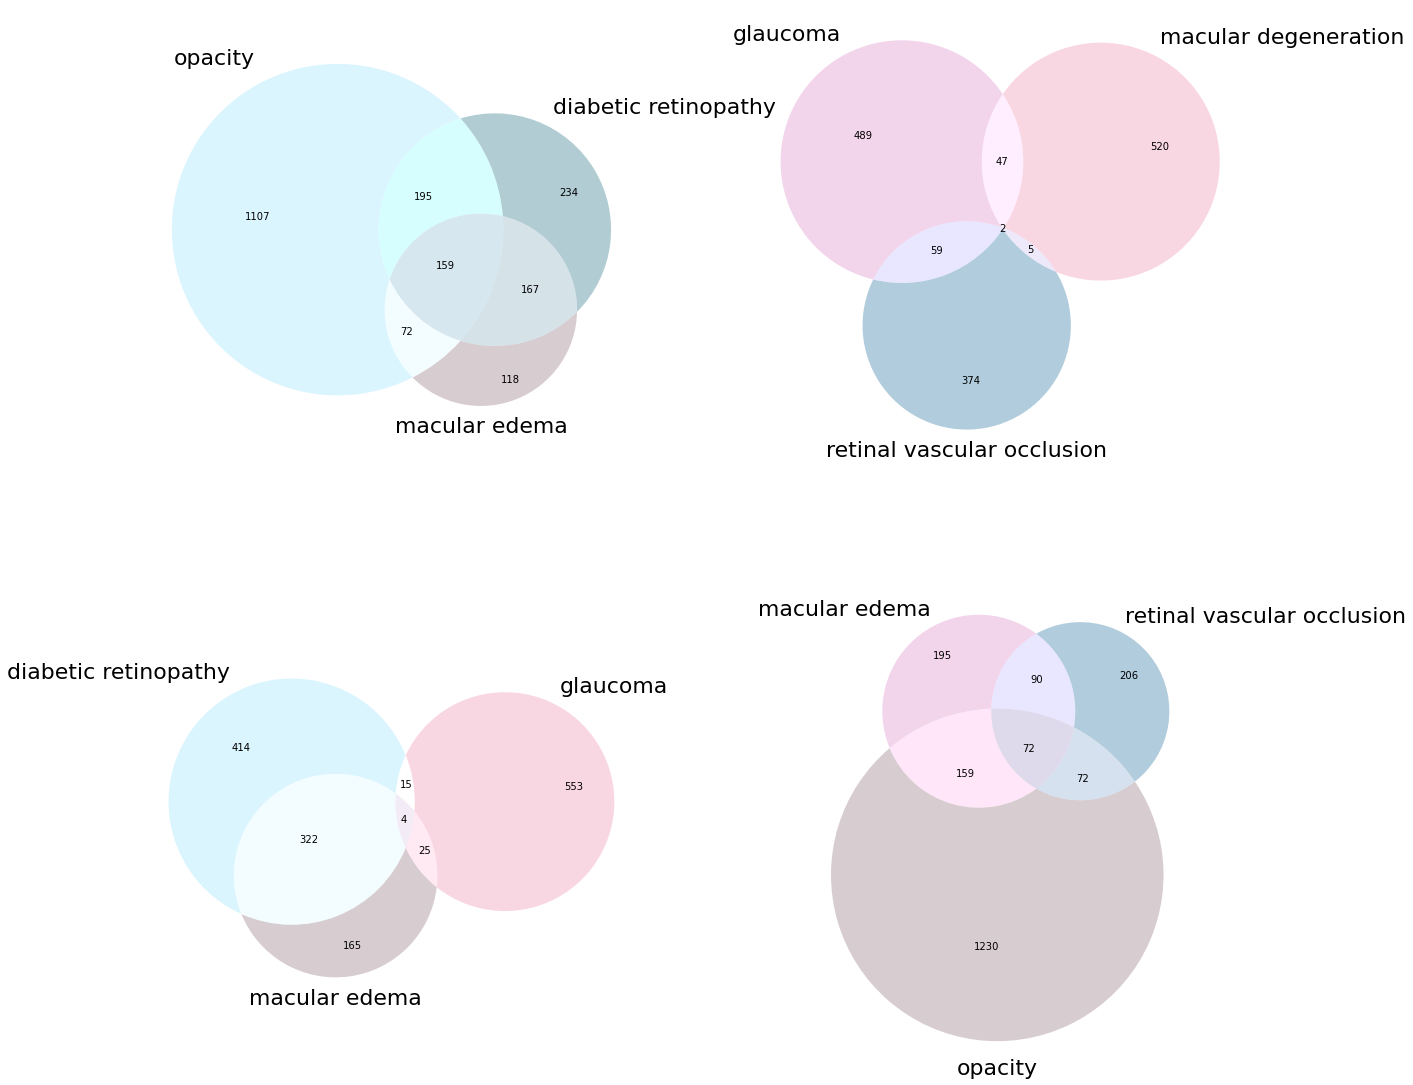

In [6]:
# Now let's explore the interrelation between categories.
venn_diagram(train_df, disease_labels, [0, 1, 3], [2, 4, 5], [1, 2, 3], [3, 5, 0])

As expected there is an overlap between the "macular edema" and the "diabetic retinopathy" disorder, and also some intersection of these two with '"opacity".

There is not much overlap between "glaucoma", "macular degeneration" and "retinal vascular occlusion".

There is also some overlap between "macular edema" and "retinal vascular oclusion".


 > ## 1.2 Setting up a data augmentation pipeline.

In the following cell I create a the dataset class containing a set of standard image transformations:


*   `transforms.Resize(224)`: for adjusting the image size to the networks' input
*   `transforms.RandomHorizontalFlip(p=1.0)`: flip the image on the horizontal edge
*   `transforms.RandomVerticalFlip(p=1.0)`: flip the image on the vertical edge
*   `transforms.Normalize()`: Normalize a tensor image with mean and standard deviation. The numbers are coming from the ImageNet dataset (This is because I will be using models pretrained on the ImageNet dataset).  




In [5]:
class RetinalDisorderDataset(Dataset):
    def __init__(self, data_file, img_dir, transform=None):
        self.img_data = data_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_data.iloc[idx]['filename'])
        image = read_image(img_path)
        image = self.transform(image)
        label = self.img_data.iloc[[idx], 1:].values
        label = torch.tensor(label, dtype=torch.float32)
        return image, torch.squeeze(label)

In [6]:
# Train (90%) and validation (10%) split.
train_data, validation_data = train_test_split(train_df, train_size=0.90, random_state=42)
print('Dataset Sizes:')
print(f'Train: {train_data.shape[0]}\nValidation: {validation_data.shape[0]}')

# Define image transforms
img_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.RandomRotation(degrees=(0, 360)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# DataFrame with train and validation info (i.e., filenames and labels)
data_df = {'train': train_data, 'val': validation_data}

# Create the dataset instances and dataloaders.
image_dataset = {x: RetinalDisorderDataset(data_file=data_df[x],
                                           img_dir='data/train/train/',
                                           transform=img_transforms[x])
                 for x in ['train', 'val']}

batch_size = 48
dataloaders = {x: DataLoader(image_dataset[x], batch_size=batch_size,
                             shuffle=True, num_workers=0)
               for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Dataset Sizes:
Train: 3091
Validation: 344
cuda:0


In [7]:
# Let's visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[x for x in classes])

In [10]:
# Training Function
def train_model(model, criterion, optimizer, scheduler, weights=None, num_epochs=25, model_name=None):
    model_name = model_name if model_name else model.__class__.__name__

    # Create the models folder (if not existing) to store the best model
    if not os.path.exists('models'): os.mkdir('models')

    since = time.time()
    # weights = weights.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    loss_history = {'train': [], 'val': []}

    for epoch in range(1, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # Set model to training or evaluation mode
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                              leave=True,
                                              total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs)
                    preds = torch.round(preds)

                    loss = criterion(outputs, labels)
                    # loss = (loss * weights).mean()
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum((preds == labels.data).all(axis=1))

            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])
            loss_history[phase].append(epoch_loss)

            # print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase.upper(), epoch_loss, epoch_acc))

            if phase == 'train':
                train_stats='{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase.upper(), epoch_loss, epoch_acc)
            else:
                print(train_stats + '{} Loss: {:.4f} Acc: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'models/' + model_name + '_v1.0.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history

In [38]:
def plot_loss_history(train_loss, val_loss):
    plt.figure(figsize=(14, 5))
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, lw=3, color='red', label='Training Loss')
    plt.plot(epochs, val_loss, lw=3, color='green', label='Validation Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid()
    plt.savefig('loss_plot.png')
    plt.show()

I address the imbalance characteristics of the data by calculating a weight vector corresponding to the labels, to pass it to the loss function. (See [this example](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).)

In [12]:
def get_pos_weight(df):
    pos_weight = []
    for c in range(df.shape[1]):
        weight = (df.iloc[:, c] == 0).sum() / (df.iloc[:, c] == 1).sum()
        pos_weight.append(weight)
    return pos_weight

For this task I'll use transfer learning. Transfer learning is increasingly used due to the availability of many pretrained models on large datasets. Additionally, since often there is not much data, and the computational resources is limited, then it is better to use transfer learning and leverage on previous work.

I will be using a pretrained ResNet18 model on the ImageNet dataset. I will freeze almost half of the model and retrain only the last 4 layers. In image classification, the features "learned" by the first layers of a model correspond to basic image features, e.g., edges, lines, simple shapes, etc. Whereas the features learned by the last layers correspond to high level features, e.g., faces, objects, etc. Therefore, it makes sense to re-train only the last layers and freeze the rest. However, it is valid to point out that this is just one approach out of a few for transfer learning.

25,557,032 total number of parameters
17,013,736 parameters to train
Epoch 1/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


TRAIN Loss: 0.8584 Acc: 6.7538
VAL Loss: 0.7770 Acc: 6.8750
Epoch 2/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


TRAIN Loss: 0.7249 Acc: 10.9692
VAL Loss: 0.6203 Acc: 11.2500
Epoch 3/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.6671 Acc: 13.1385
VAL Loss: 0.6215 Acc: 15.3750
Epoch 4/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.6453 Acc: 14.7231
VAL Loss: 0.5764 Acc: 14.0000
Epoch 5/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.6121 Acc: 15.5846
VAL Loss: 0.6463 Acc: 16.5000
Epoch 6/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.5914 Acc: 16.0923
VAL Loss: 0.6250 Acc: 15.3750
Epoch 7/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.5699 Acc: 16.8154
VAL Loss: 0.6157 Acc: 13.7500
Epoch 8/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.5463 Acc: 18.1385
VAL Loss: 0.6091 Acc: 17.0000
Epoch 9/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


TRAIN Loss: 0.5389 Acc: 17.4923
VAL Loss: 0.6063 Acc: 16.2500
Epoch 10/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.5403 Acc: 18.1538
VAL Loss: 0.6047 Acc: 15.6250
Epoch 11/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.5258 Acc: 18.4462
VAL Loss: 0.5034 Acc: 17.0000
Epoch 12/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


TRAIN Loss: 0.5180 Acc: 18.6154
VAL Loss: 0.5519 Acc: 17.1250
Epoch 13/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


TRAIN Loss: 0.5091 Acc: 18.8000
VAL Loss: 0.5392 Acc: 16.3750
Epoch 14/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


TRAIN Loss: 0.4963 Acc: 18.8000
VAL Loss: 0.5254 Acc: 16.3750
Epoch 15/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


TRAIN Loss: 0.4850 Acc: 19.5231
VAL Loss: 0.4969 Acc: 18.2500
Epoch 16/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


TRAIN Loss: 0.4754 Acc: 20.1385
VAL Loss: 0.5903 Acc: 18.6250
Epoch 17/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4656 Acc: 20.0615
VAL Loss: 0.5154 Acc: 17.1250
Epoch 18/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


TRAIN Loss: 0.4609 Acc: 21.1231
VAL Loss: 0.5021 Acc: 18.5000
Epoch 19/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4610 Acc: 20.6308
VAL Loss: 0.5272 Acc: 17.3750
Epoch 20/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.4565 Acc: 20.3077
VAL Loss: 0.5125 Acc: 17.7500
Epoch 21/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4476 Acc: 21.0000
VAL Loss: 0.4943 Acc: 17.7500
Epoch 22/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4360 Acc: 21.8615
VAL Loss: 0.4736 Acc: 20.7500
Epoch 23/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4263 Acc: 21.5231
VAL Loss: 0.4804 Acc: 19.5000
Epoch 24/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4182 Acc: 22.0462
VAL Loss: 0.5648 Acc: 20.3750
Epoch 25/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.4143 Acc: 21.8462
VAL Loss: 0.4762 Acc: 20.6250
Epoch 26/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


TRAIN Loss: 0.4090 Acc: 22.4923
VAL Loss: 0.5045 Acc: 20.6250
Epoch 27/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.3935 Acc: 23.5231
VAL Loss: 0.4450 Acc: 21.2500
Epoch 28/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.4026 Acc: 22.4923
VAL Loss: 0.5042 Acc: 20.1250
Epoch 29/30
----------


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


TRAIN Loss: 0.3953 Acc: 23.4000
VAL Loss: 0.5088 Acc: 19.6250
Training complete in 70m 54s
Best val Loss: 0.445000


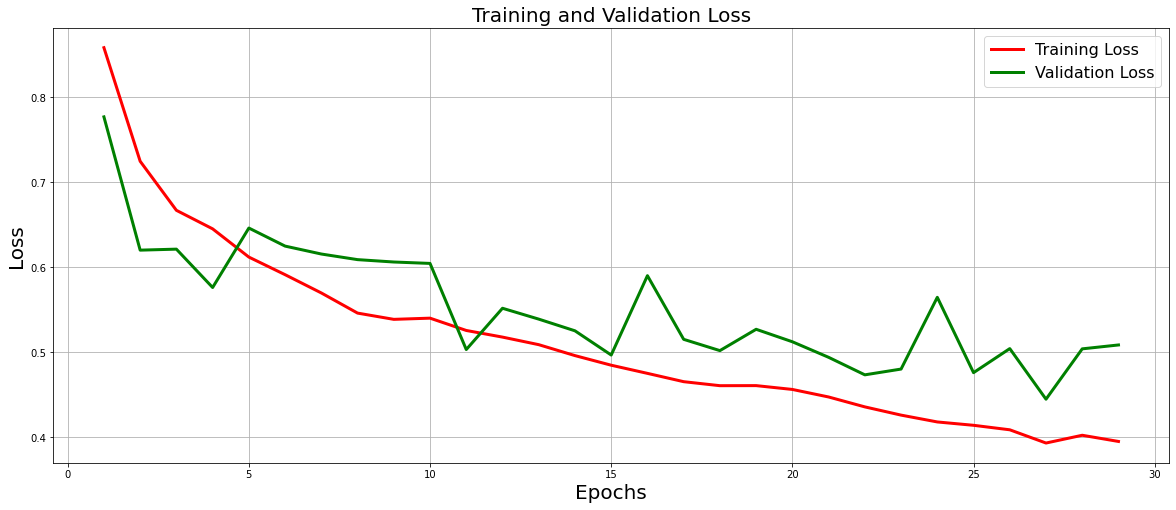

In [13]:
lr = 0.0001
epochs = 30
model = models.resnet50(pretrained=True, progress=True)

# ResNet50 has 4 layers, let's freeze the first three, and re-train only the last ones.
for sub_layer in [model.conv1, model.bn1, model.layer1, model.layer2, model.layer3]:
    for param in sub_layer.parameters():
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(disease_labels))

model = model.to(device)


pos_weight = get_pos_weight(train_df.iloc[:, 1:])
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, loss_history = train_model(model, criterion, optimizer, exp_lr_scheduler,
                                  num_epochs=epochs, model_name='ResNet50')

plot_loss_history(loss_history['train'], loss_history['val'])

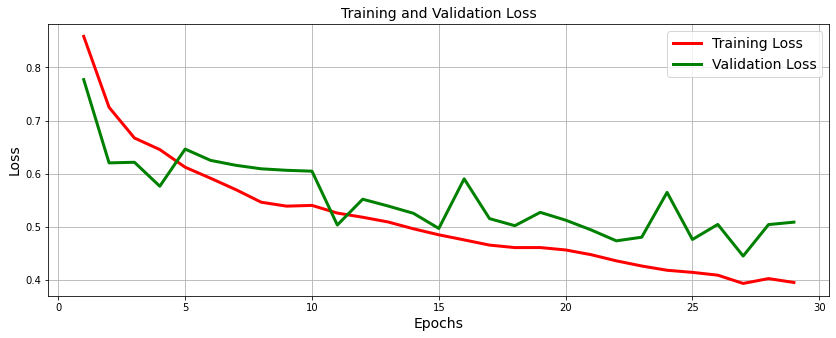

In [39]:
plot_loss_history(loss_history['train'], loss_history['val'])

In [48]:
def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                actual_labels = [disease_labels[idx] for idx, value in enumerate(labels[j]) if value == 1]
                predicted_labels = [disease_labels[idx] for idx, value in enumerate(outputs[j]) if value == 1]
                ax.set_title(f'Actual: {actual_labels}\n Predicted: {predicted_labels}')
                imshow(inputs.cpu().data[j])
                plt.figure(figsize=(10, 10))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

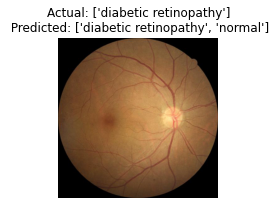

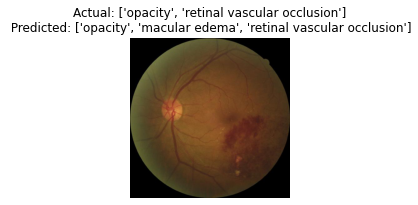

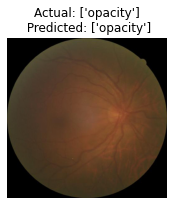

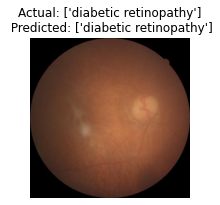

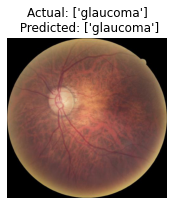

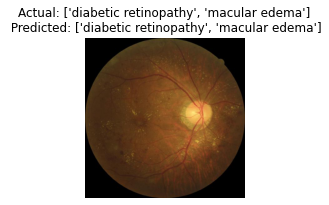

<Figure size 720x720 with 0 Axes>

In [49]:
# print([disease_labels[idx] for idx, value in enumerate(test_array) if value == 1])

# Making some predictions on the test dataset:
visualize_model_predictions(model, num_images=6)

The predictions of the model are quite accurate, as evidence in the previous images.

### Statistics on the validation dataset:

In [70]:
# Function to evaluate the model performance on the test dataset.
def test_model(model, data_split='val'):
    model.eval()
    Acc, Prec, Rec, F1 = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in iter(dataloaders[data_split]):
            inputs = inputs.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            
            y_true, y_pred = labels, outputs.detach().cpu()

            Acc += accuracy_score(y_true, y_pred)
            Prec += precision_score(y_true, y_pred, average="samples", zero_division=0)
            Rec += recall_score(y_true, y_pred, average="samples", zero_division=0)
            F1 += f1_score(y_true, y_pred, average="samples", zero_division=0)
        
        Acc = Acc / len(dataloaders[data_split])
        Prec = Prec / len(dataloaders[data_split])
        Rec = Rec / len(dataloaders[data_split])
        F1 = F1 / len(dataloaders[data_split])
        
    return Acc, Prec, Rec, F1

In [69]:
Acc, Prec, Rec, F1 = test_model(model, data_split='val')
print('Evaluation on the test dataset:')
print('Accuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}'.format(
    Acc, Prec, Rec, F1))

Evaluation on the test dataset:
Accuracy:0.508
Precision:0.752
Recall:0.893
F1:0.792


|Model        | Accuracy  | Precision | Recall | F1     | 
|-------------|-----------|-----------|--------|--------|
|**Resnet50** | 0.508     | 0.752     | 0.893  | 0.792  | 

### Predictions on the test dataset

The test dataset consists of 350 unlabeled retinal images. Therefore, I will load them, make predictions and save in a *.csv file the filenames and predicted labels.

In [25]:
# Define the test dataset that just read the test image files and returns the image and filename.
class RetinalDisorderTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_file = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_file)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_file[idx])
        image = read_image(img_path)
        image = self.transform(image)
        filename = self.img_file[idx]
        return image, filename


# Function to make predictions on the test dataset.
def predict_test_data(model, data_split='test'):
    results_df = pd.DataFrame()
    model.eval()
    with torch.no_grad():
        for inputs, filename in iter(dataloaders[data_split]):
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            
            df_entry = pd.DataFrame(data=np.hstack((np.asarray(filename).reshape(-1, 1), outputs.cpu().numpy())))
            results_df = pd.concat([results_df, df_entry], ignore_index=True)
        results_df.columns = ['filename'] + list(disease_labels)
    return results_df

In [26]:
# Load the model (ResNet50)
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(disease_labels))
model.load_state_dict(torch.load('models/ResNet50_v1.0.ipynb.pth'))
model = model.to(device)

# Create the dataset and dataloader test instances.
image_dataset['test'] = RetinalDisorderTestDataset(img_dir='data/test',
                                                   transform=img_transforms['test'])

dataloaders['test'] = DataLoader(image_dataset['test'], batch_size=batch_size,
                                 num_workers=0)

test_results = predict_test_data(model, data_split='test')

In [35]:
print(test_results.shape)
test_results.to_csv('data/test/test.csv', sep=',')
test_results.head(n=100)

(350, 8)


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,012df36af16b.jpg,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0157f50bdb02.jpg,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,026aa5bc0aea.jpg,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,03e7e29071a5.jpg,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,071ac96c6277.jpg,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
95,45a9a190d974.jpg,1.0,1.0,0.0,0.0,0.0,0.0,0.0
96,474a91fb70d1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,4819d3d87d8c.jpg,1.0,1.0,0.0,1.0,0.0,0.0,0.0
98,489a8eca4c9b.jpg,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# 2. Visualizing regions of interest that contribute to the prediction of retinal disorders.

For this task I hand-picked a few images from the test dataset to showcase different retinal disorders. I base my approcah on [this work](https://github.com/jacobgil/pytorch-grad-cam).

In [32]:
from PIL import Image
import cv2
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image

In [33]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.shape[0] + im2.shape[0], im1.shape[1]))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.shape[0], 0))
    return dst

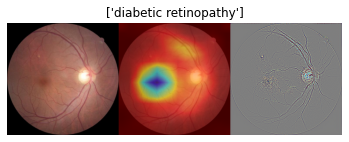

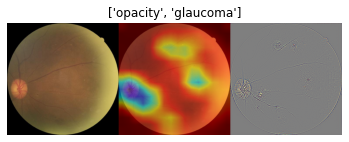

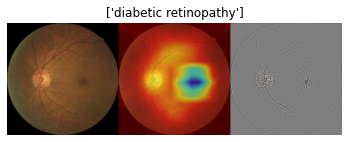

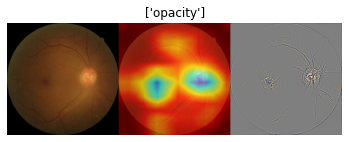

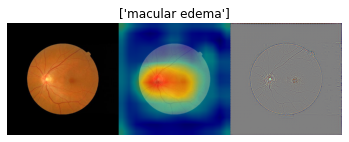

In [34]:
# model = model_ft2
target_layers = [model.layer4[-1]]

# Examples images from the test dataset. These where selected manually to showcase different retinal disrders.
example_images = (('data/train/train/30c12f1232bb.jpg', [0, 1, 0, 0]),
                ('data/train/train/0054be0a30b1.jpg', [1, 0, 1, 0]),
                ('data/train/train/50af8887791e.jpg', [0, 1, 0, 0]),
                ('data/train/train/ef8933d65998.jpg', [1, 0, 0, 0]),
                ('data/train/train/4b6f2e8f0a3d.jpg', [0, 0, 0, 1]))

for img_path, label in example_images:
    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    target_category = None
    with GradCAM(model=model,
                 target_layers=target_layers,
                 use_cuda=True) as cam:

        cam.batch_size = 32

        grayscale_cam = cam(input_tensor=input_tensor,
                            target_category=target_category,
                            aug_smooth=True,
                            eigen_smooth=True)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, target_category=target_category)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    method = 'GradCAM'
    # cv2.imwrite(f'{method}_cam.jpg', cam_image)
    # cv2.imwrite(f'{method}_gb.jpg', gb)
    # cv2.imwrite(f'{method}_cam_gb.jpg', cam_gb)

    visualization = show_cam_on_image(rgb_img, grayscale_cam)

    ims = np.concatenate((rgb_img,
                          np.float32(visualization)/255,
                          np.float32(gb)/255
                         ), axis=1)

    labels = [disease_labels[idx] for idx, value in enumerate(label) if value == 1]

    plt.title(labels)
    plt.axis("off")
    plt.imshow(ims)
    plt.show()

The images above show the regions of "interest" that cause the model to make a particular prediction. Areas colored in red being important and blue less important. It can be seen in the first image that for that particular case of glaucoma, the model focused on some edges of the retina and on a spot near the center to the left. On the other hand the last three images the focus of the network is not as evident like the first images, but a close look revelas light yellow areas which is where the model focused in these cases to make a prediction. 